# Tweet Sentiment Extraction
### Extract support phrases for sentiment labels

With all of the tweets circulating every second it is hard to tell whether the sentiment behind a specific tweet will impact a company, or a person's, brand for being viral (positive), or devastate profit because it strikes a negative tone. Capturing sentiment in language is important in these times where decisions and reactions are created and updated in seconds. But, which words actually lead to the sentiment description? In this competition you will need to pick out the part of the tweet (word or phrase) that reflects the sentiment.

In this competition we've extracted support phrases from Figure Eight's Data for Everyone platform. The dataset is titled Sentiment Analysis: Emotion in Text tweets with existing sentiment labels, used here under creative commons attribution 4.0. international licence. Your objective in this competition is to construct a model that can do the same - look at the labeled sentiment for a given tweet and figure out what word or phrase best supports it.

In this section we made detailed analisys of input data and prepare some functions for preprocessing data. 

Main parts:
1. Libraries
2. Loading dataset
3. EDA
    - Missing Values treatment in the dataset
    - Distribution of the Sentiment Column
    - Text Data Preprocessing
    - Analyzing Text Statistics

Final dataset may be used as input data for ML.

# 1. Import libraries

In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
import nltk
import re
import string
import seaborn as sns
import pandas as pd
import numpy as np
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# We need to install a wide variety of libraries. For this we will install pandas, numpy, seaborn and matplotlib libraries.
sns.set()


warnings.filterwarnings("ignore")

# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'

/kaggle/input/tweet-sentiment-extraction/sample_submission.csv
/kaggle/input/tweet-sentiment-extraction/train.csv
/kaggle/input/tweet-sentiment-extraction/test.csv


# 2. Reading the datasets

In [2]:
train_data = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/train.csv")
test_data = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/test.csv")
train_data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [3]:
train_data.describe()

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11118


# 3. EDA
## Missing Values treatment in the dataset

In [4]:
train_data.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

We found one row is missing for text and selected_text, so we need to replace it or drop it.

In [5]:
# Dropping missing values
train_data.dropna(inplace=True)

## Distribution of the Sentiment Column

In [6]:
train_data['sentiment'].value_counts()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [7]:
train_data['sentiment'].value_counts(normalize=True)

neutral     0.404549
positive    0.312300
negative    0.283151
Name: sentiment, dtype: float64

<AxesSubplot:xlabel='sentiment', ylabel='count'>

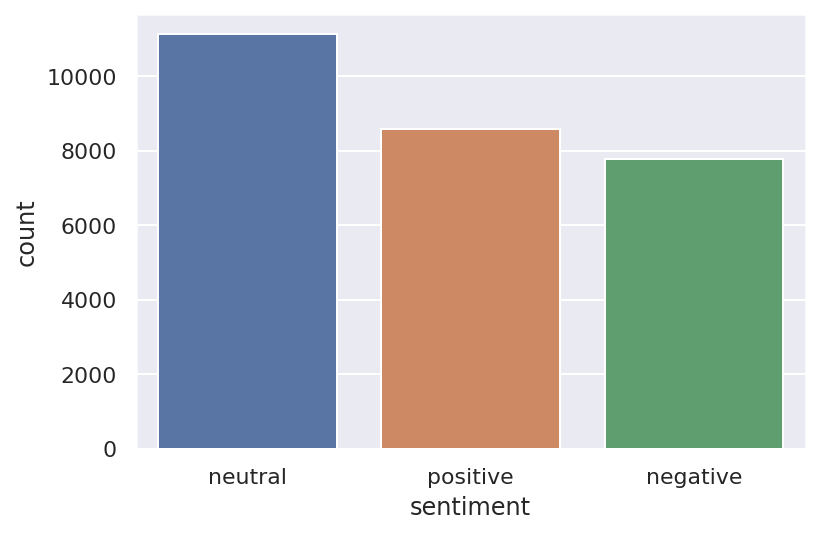

In [8]:
sns.countplot(data=train_data, x='sentiment',
              order=train_data['sentiment'].value_counts().index)

Examples of each sentiment

In [9]:
# Positive tweet
print('Positive Tweet example:',
      train_data[train_data['sentiment'] == 'positive']['text'].values[0])

# Negative tweet
print('Negative Tweet example:',
      train_data[train_data['sentiment'] == 'negative']['text'].values[0])

# Neutral tweet
print('Neutral Tweet example:',
      train_data[train_data['sentiment'] == 'neutral']['text'].values[0])

Positive Tweet example: 2am feedings for the baby are fun when he is all smiles and coos
Negative Tweet example:  Sooo SAD I will miss you here in San Diego!!!
Neutral Tweet example:  I`d have responded, if I were going


## Text Data Preprocessing
We need to pre-process the data to get it all in a consistent format.We need to clean, tokenize and convert our data into a matrix. Let's create a function which will perform the following tasks on the text columns:

- Tokenizes
- Make text lowercase
- Removes hyperlinks
- Remove punctuation
- Removes numbers
- Removes useless words "stopwords"
- Stemming/Lemmatization

In [10]:
stop_words = stopwords.words('english')
stemmer = nltk.SnowballStemmer("english")


def clean_text(text):
    '''
        Make text lowercase, remove text in square brackets,remove links,remove punctuation
        and remove words containing numbers.
    '''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S|www\.\S', '', text)  # remove urls
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation),
                  '', text)  # remove punctuation
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


def preprocess_data(text):
    """
       Clean puntuation, urls, and so on, 
       removing stop-words and make stemming
    """
    text = clean_text(text)
    # Remove stop-words
    text = ' '.join(word for word in text.split()
                    if word not in stop_words)    # Remove stopwords
    # Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split())
    return text

In [11]:
train_data['clean_text'] = train_data['text'].apply(preprocess_data)
train_data.head()

,textID,text,selected_text,sentiment,clean_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,id respond go
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad miss san diego
2,088c60f138,my boss is bullying me...,bullying me,negative,boss bulli
3,9642c003ef,what interview! leave me alone,leave me alone,negative,interview leav alon
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,son couldnt put releas alreadi bought


In [12]:
# Convert sentiment to numerical variable
train_data['label'] = train_data.sentiment.map({'negative': 0,
                                                'positive': 1,
                                                'neutral': 2})
train_data.head()

,textID,text,selected_text,sentiment,clean_text,label
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,id respond go,2
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad miss san diego,0
2,088c60f138,my boss is bullying me...,bullying me,negative,boss bulli,0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,interview leav alon,0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,son couldnt put releas alreadi bought,0


## Analyzing Text Statistics

We can now do some statistical analysis to explore the data like:

- Text length analysis
- length for whole sentence
- count of word in each sentence
- word frequency analysis

### Text length analysis

In [13]:
train_data['text_n_chars'] = train_data.text.apply(
    len)  # count all chars in each sentence
train_data['text_n_words'] = train_data.text.apply(
    lambda sent: len(sent.split()))  # count number of words in each sentence
train_data.head()

,textID,text,selected_text,sentiment,clean_text,label,text_n_chars,text_n_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,id respond go,2,36,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad miss san diego,0,46,10
2,088c60f138,my boss is bullying me...,bullying me,negative,boss bulli,0,25,5
3,9642c003ef,what interview! leave me alone,leave me alone,negative,interview leav alon,0,31,5
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,son couldnt put releas alreadi bought,0,75,14


<AxesSubplot:xlabel='text_n_words', ylabel='Count'>

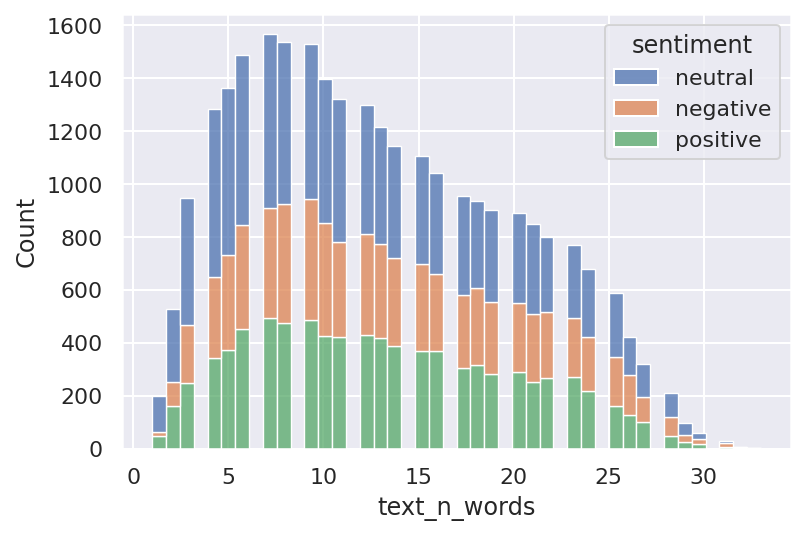

In [14]:
# The distribution of number of words for each sentiment
sns.histplot(data=train_data, x='text_n_words',
             hue='sentiment', multiple='stack')

### Most frequent words. In whole Text.

In [15]:
words = [word for sent in train_data['clean_text'] for word in sent.split()]
words[:10]  # words without sorting

['id', 'respond', 'go', 'sooo', 'sad', 'miss', 'san', 'diego', 'boss', 'bulli']

In [16]:
# sort words descending order
freq_words = Counter(words)
freq_words_sorted = sorted(
    freq_words.items(), key=lambda pair: pair[1], reverse=True)
freq_words_df = pd.DataFrame(
    freq_words_sorted[:20], columns=['word', 'counts'])
freq_words_df.head(10)

,word,counts
0,im,3023
1,day,2368
2,go,2363
3,get,1908
4,good,1569
5,work,1483
6,love,1458
7,like,1454
8,dont,1200
9,today,1114


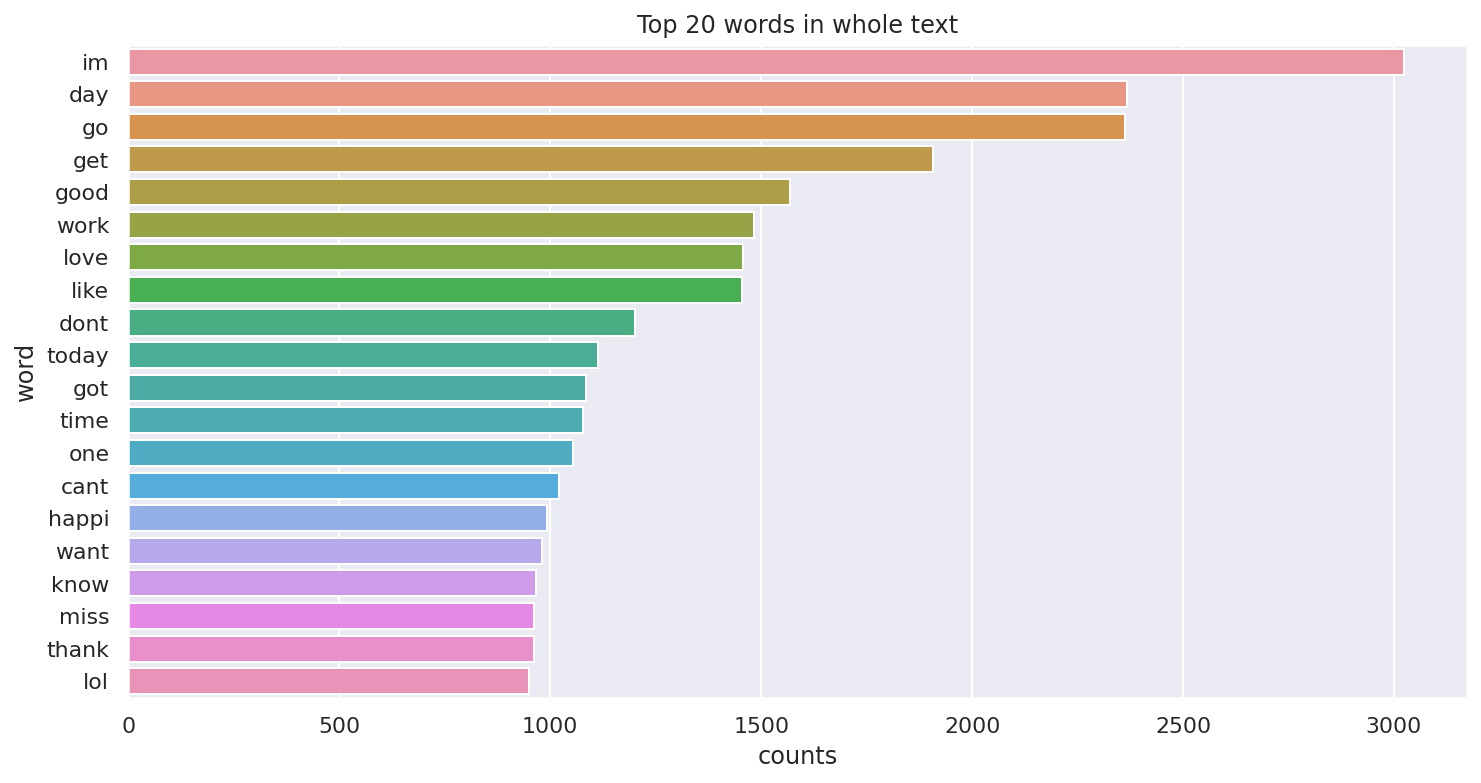

In [17]:
plt.figure(figsize=(12, 6))
sns.barplot(data=freq_words_df, x='counts', y='word')
plt.title('Top 20 words in whole text')
plt.show()

### Frequent words for each sentiment

In [18]:
def freq_sentiment_words(text, sentiment, num):
    '''
        take the whole data, and return data which is have # of words 
        in each sentiment has been passed
    '''
    words = [word for sent in text[text['sentiment'] == sentiment]
             ['clean_text'] for word in sent.split()]
    freq_words = Counter(words)
    freq_words_sorted = sorted(
        freq_words.items(), key=lambda pair: pair[1], reverse=True)
    freq_words_df = pd.DataFrame(
        freq_words_sorted[:num], columns=['word', 'counts'])
    return freq_words_df


def plot_freq(data, st):
    '''
        take the data, and st refeere to kind of sentiment
    '''
    plt.figure(figsize=(12, 6))
    sns.barplot(data=data, x='counts', y='word')
    plt.title(f'Top 20 words in {st} sentiment')
    plt.show()

    word  counts
0    day    1326
1   love    1141
2   good    1056
3  happi     852
4  thank     814


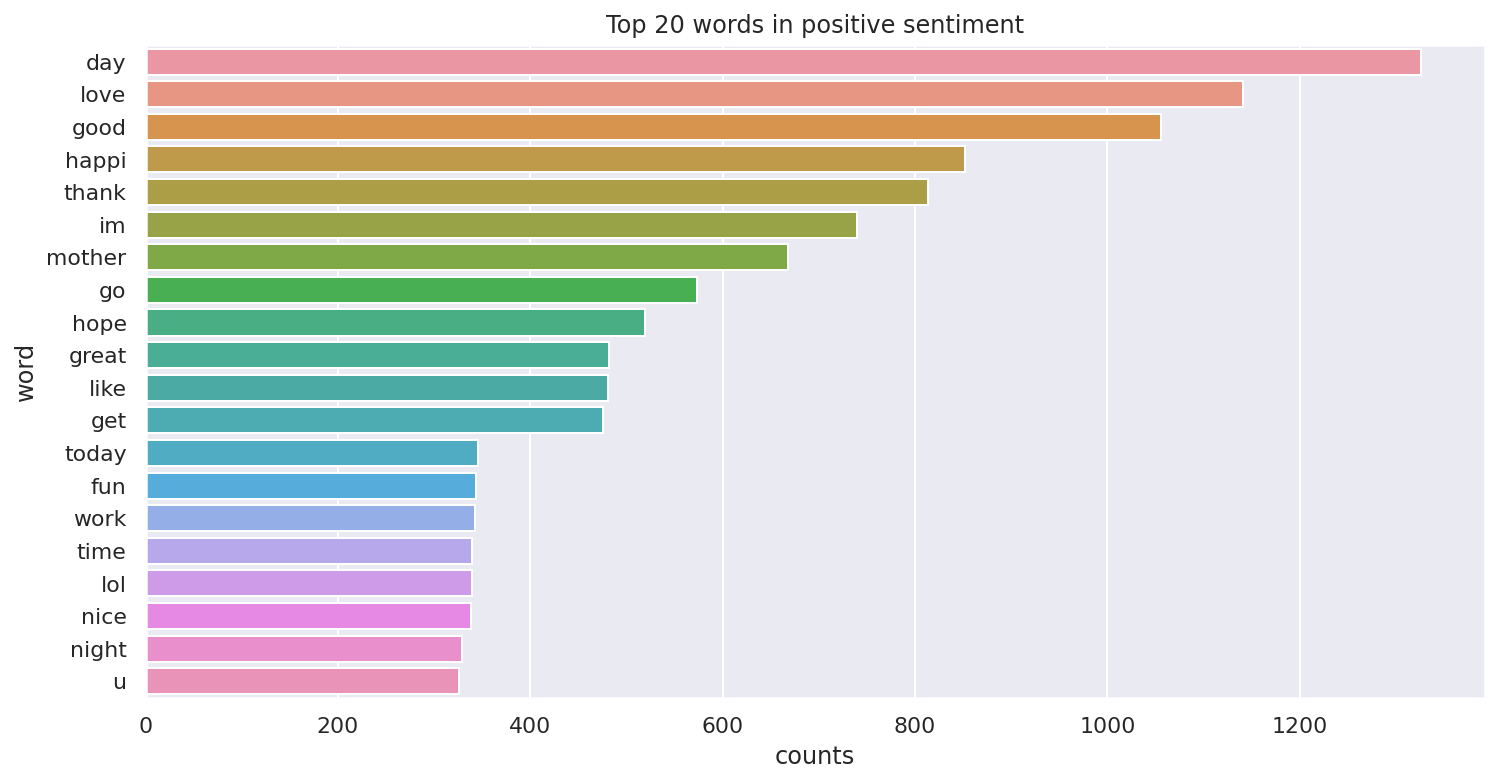

In [19]:
# In Positive Sentiment
positive_words = freq_sentiment_words(train_data, 'positive', 20)
print(positive_words.head())
plot_freq(positive_words, 'positive')

   word  counts
0    im    1227
1    go     735
2  miss     660
3   get     613
4  work     493


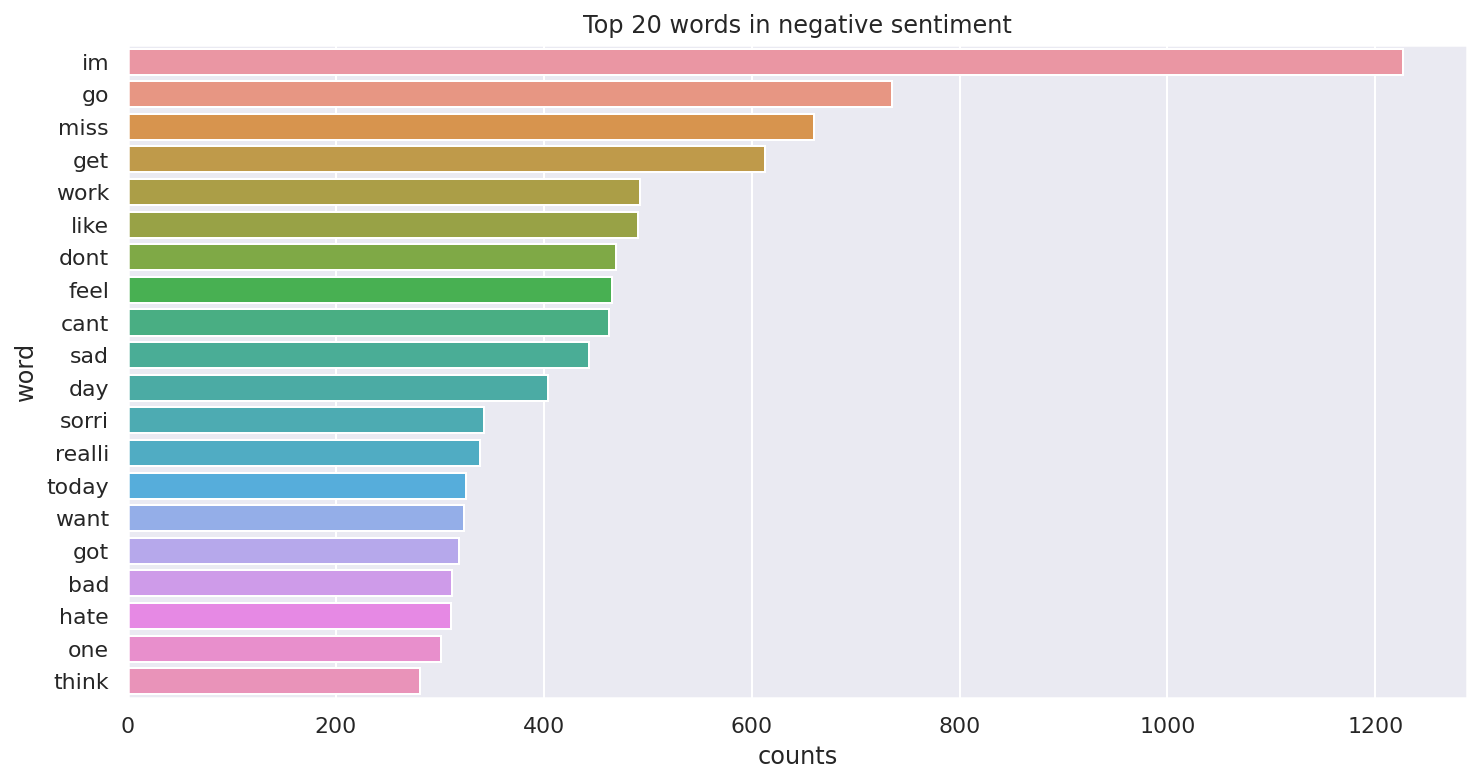

In [20]:
# In Negative Sentiment
negative_words = freq_sentiment_words(train_data, 'negative', 20)
print(negative_words.head())
plot_freq(negative_words, 'negative')

   word  counts
0    im    1056
1    go    1055
2   get     819
3  work     647
4   day     638


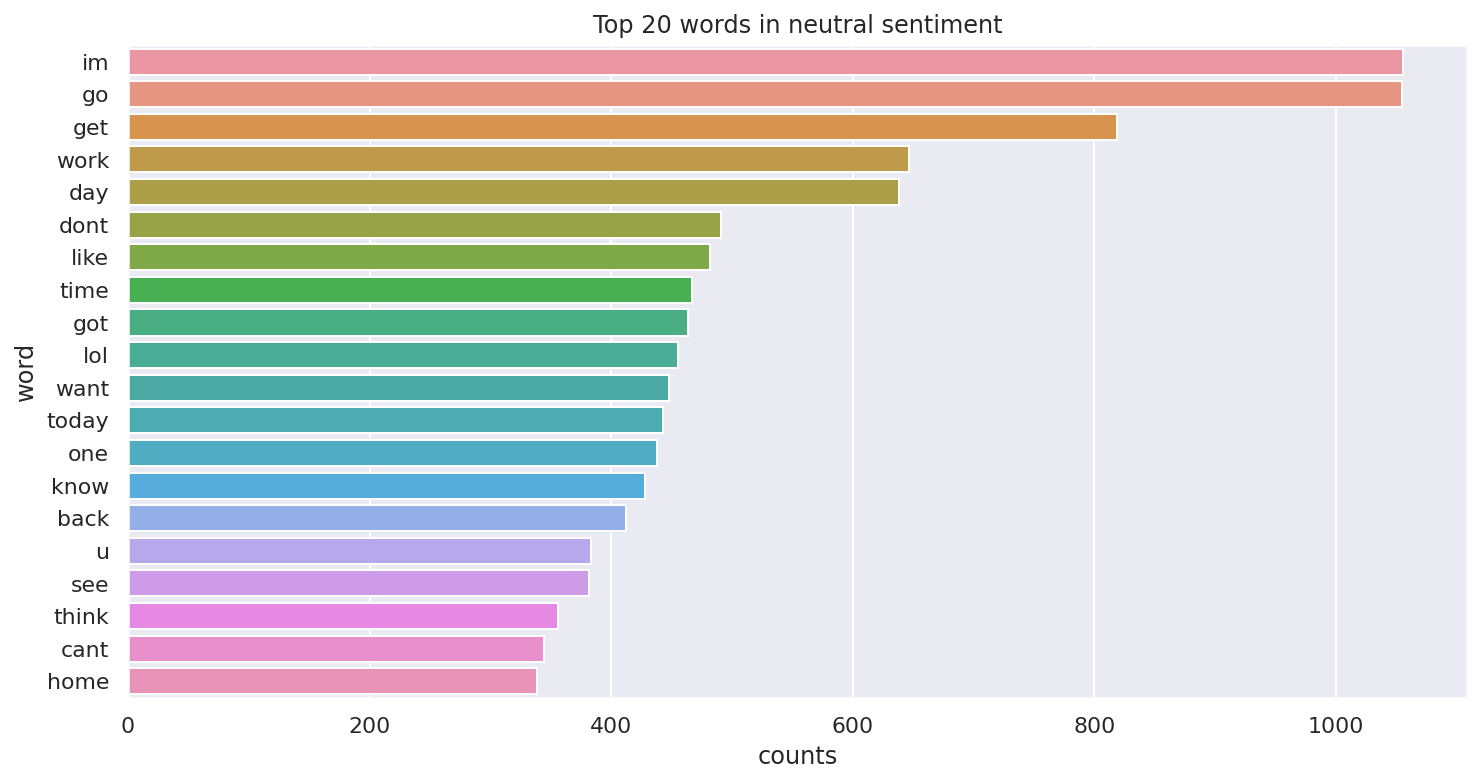

In [21]:
# In Neutral Sentiment
neutral_words = freq_sentiment_words(train_data, 'neutral', 20)
print(neutral_words.head())
plot_freq(neutral_words, 'neutral')

### Distribution of top n-grams

In [22]:
def get_top_n_gram(corpus, sentiment,  n_gram, top_n=None):
    """
        Creates n-gram distribution and returns top n elements
    """
    # list of splited senteces, which is just list of words
    text = [word for sent in corpus[corpus['sentiment'] ==
                                    sentiment]['clean_text'] for word in sent.split()]

    grams = ngrams(text, n_gram)
    grams = (' '.join(g) for g in grams)
    num_of_grams = [words for words in grams]
    freq_words = Counter(num_of_grams)
    freq_words_sorted = sorted(
        freq_words.items(), key=lambda pair: pair[1], reverse=True)
    freq_words_df = pd.DataFrame(
        freq_words_sorted[:top_n], columns=['word', 'counts'])
    return freq_words_df[:top_n]

           word  counts
0    mother day     547
1  happi mother     438
2     good morn     140
3     cant wait     104
4       day mom      72


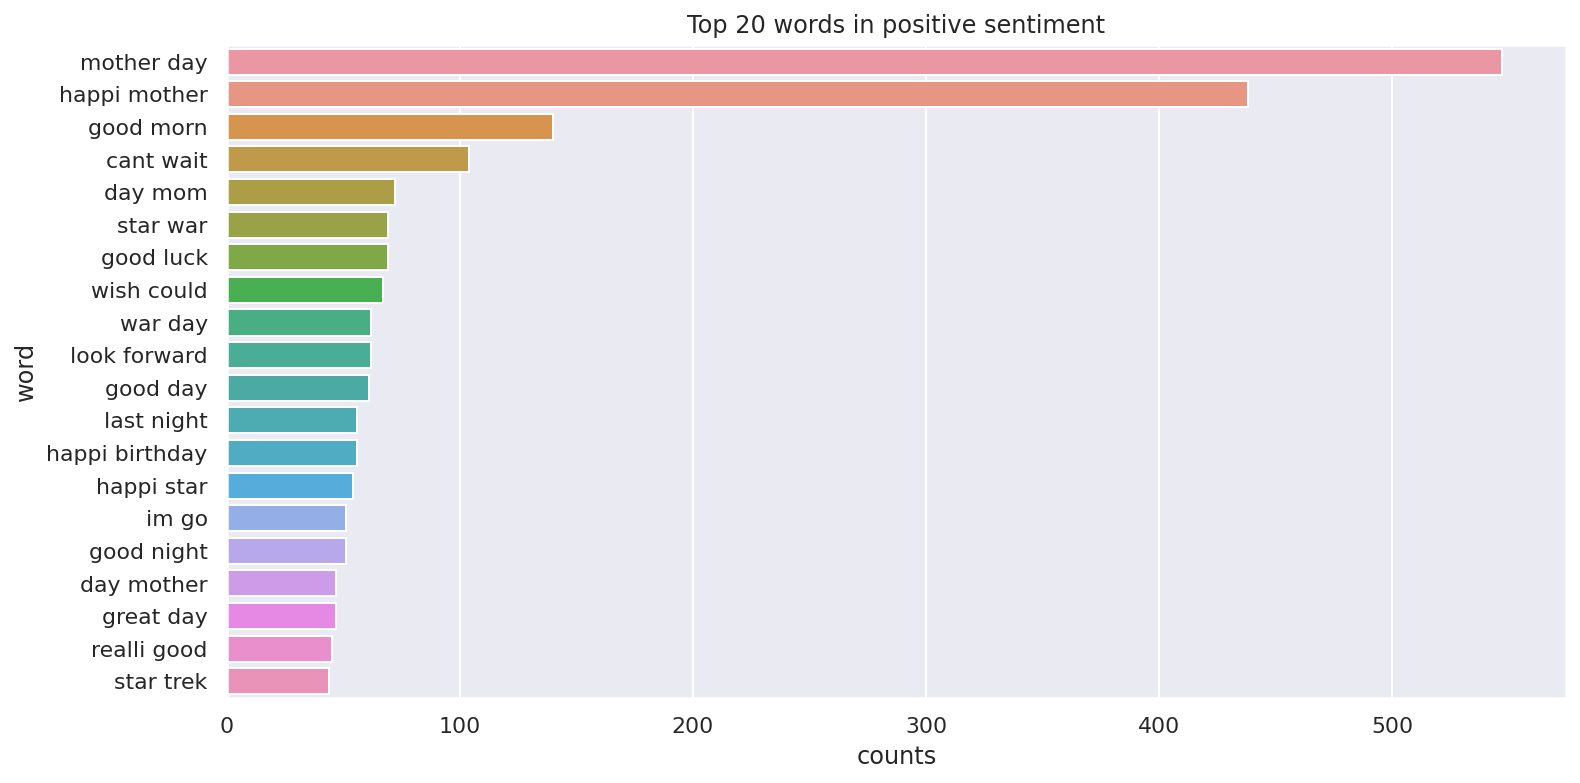

In [23]:
# Bi-Gram for positive sentiment
positive_gram = get_top_n_gram(train_data, 'positive', 2, 20)
print(positive_gram.head())
plot_freq(positive_gram, 'positive')

        word  counts
0  feel like     103
1   im sorri      80
2      im go      65
3  dont know      55
4  look like      54


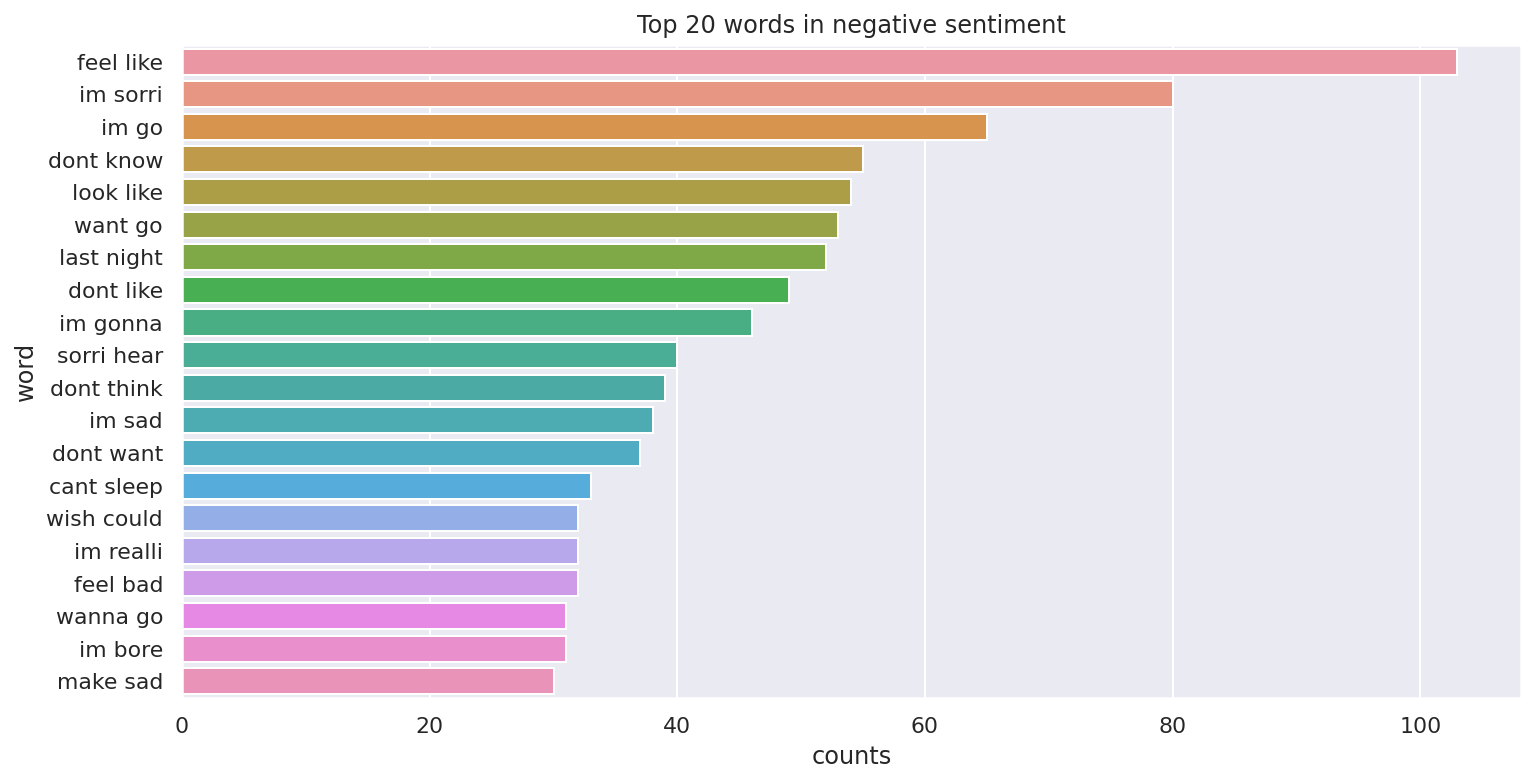

In [24]:
# Bi-Gram for negative sentiment
negative_gram = get_top_n_gram(train_data, 'negative', 2, 20)
print(negative_gram.head())
plot_freq(negative_gram, 'negative')

         word  counts
0   dont know      83
1       im go      73
2  last night      71
3  mother day      70
4   look like      58


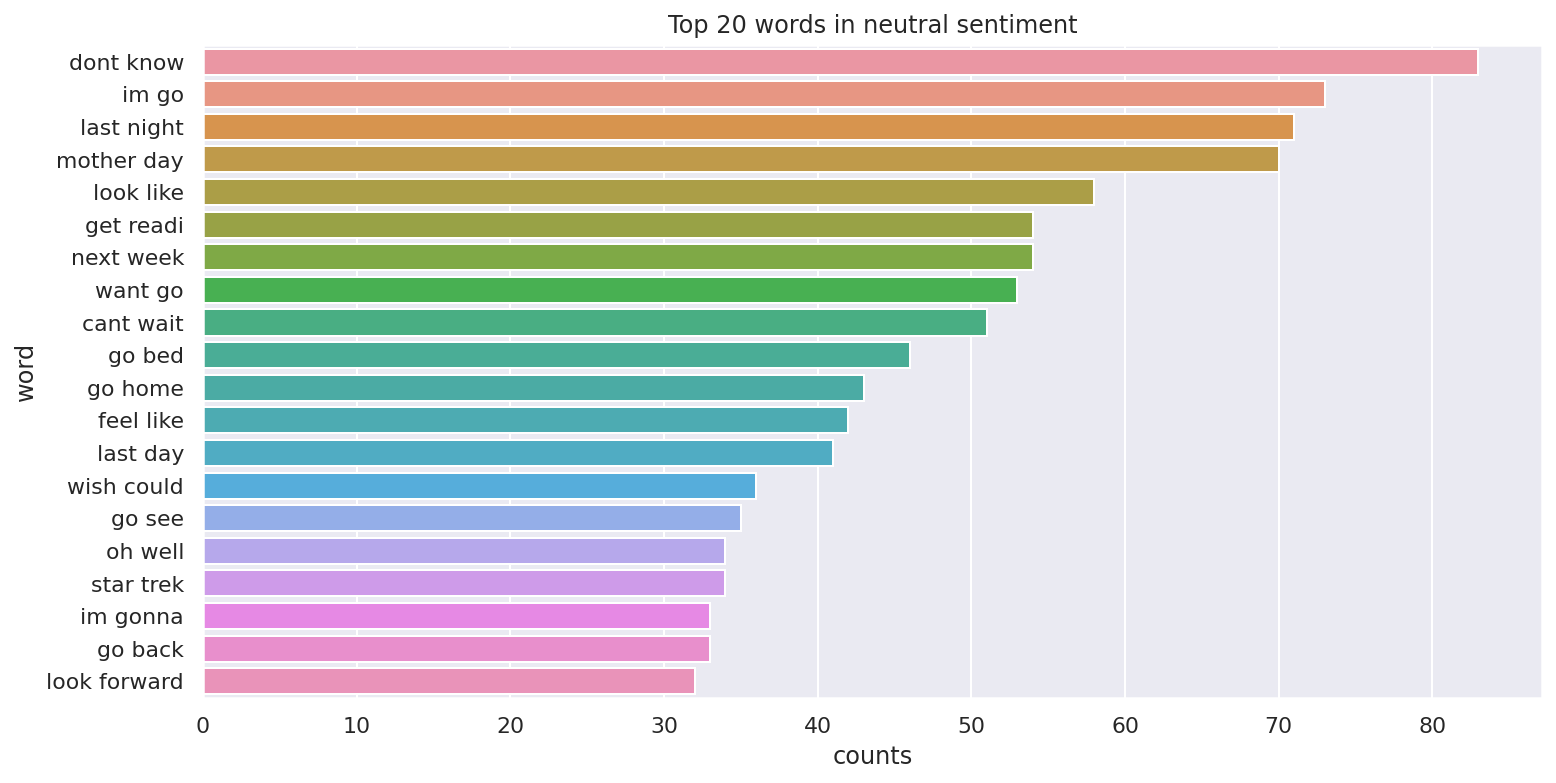

In [25]:
# Bi-Gram for neutral sentiment
netutral_gram = get_top_n_gram(train_data, 'neutral', 2, 20)
print(netutral_gram.head())
plot_freq(netutral_gram, 'neutral')

We can easily make tri-grams for sentiment using this function get_top_n_gram by passing n_gram = 3

### Word Cloud

In [26]:
# getting list of positive words
positive_text_clean = train_data[train_data['sentiment']
                                 == 'positive']['clean_text']
positive_clean_words = [
    word for words in positive_text_clean for word in words.split()]
positive_clean_words[:10]

['feed',
 'babi',
 'fun',
 'smile',
 'coo',
 'journey',
 'wow',
 'u',
 'becam',
 'cooler']

In [27]:
# getting list of negative words
negative_text_clean = train_data[train_data['sentiment']
                                 == 'negative']['clean_text']
negative_clean_words = [
    word for words in negative_text_clean for word in words.split()]
negative_clean_words[:10]

['sooo',
 'sad',
 'miss',
 'san',
 'diego',
 'boss',
 'bulli',
 'interview',
 'leav',
 'alon']

In [28]:
# getting list of neutral words
neutral_text_clean = train_data[train_data['sentiment']
                                == 'neutral']['clean_text']
neutral_clean_words = [
    word for words in neutral_text_clean for word in words.split()]
neutral_clean_words[:10]

['id',
 'respond',
 'go',
 'wwdothebouncycomsmf',
 'shameless',
 'plug',
 'best',
 'ranger',
 'forum',
 'earth']

Text(0.5, 1.0, 'Neutral text')

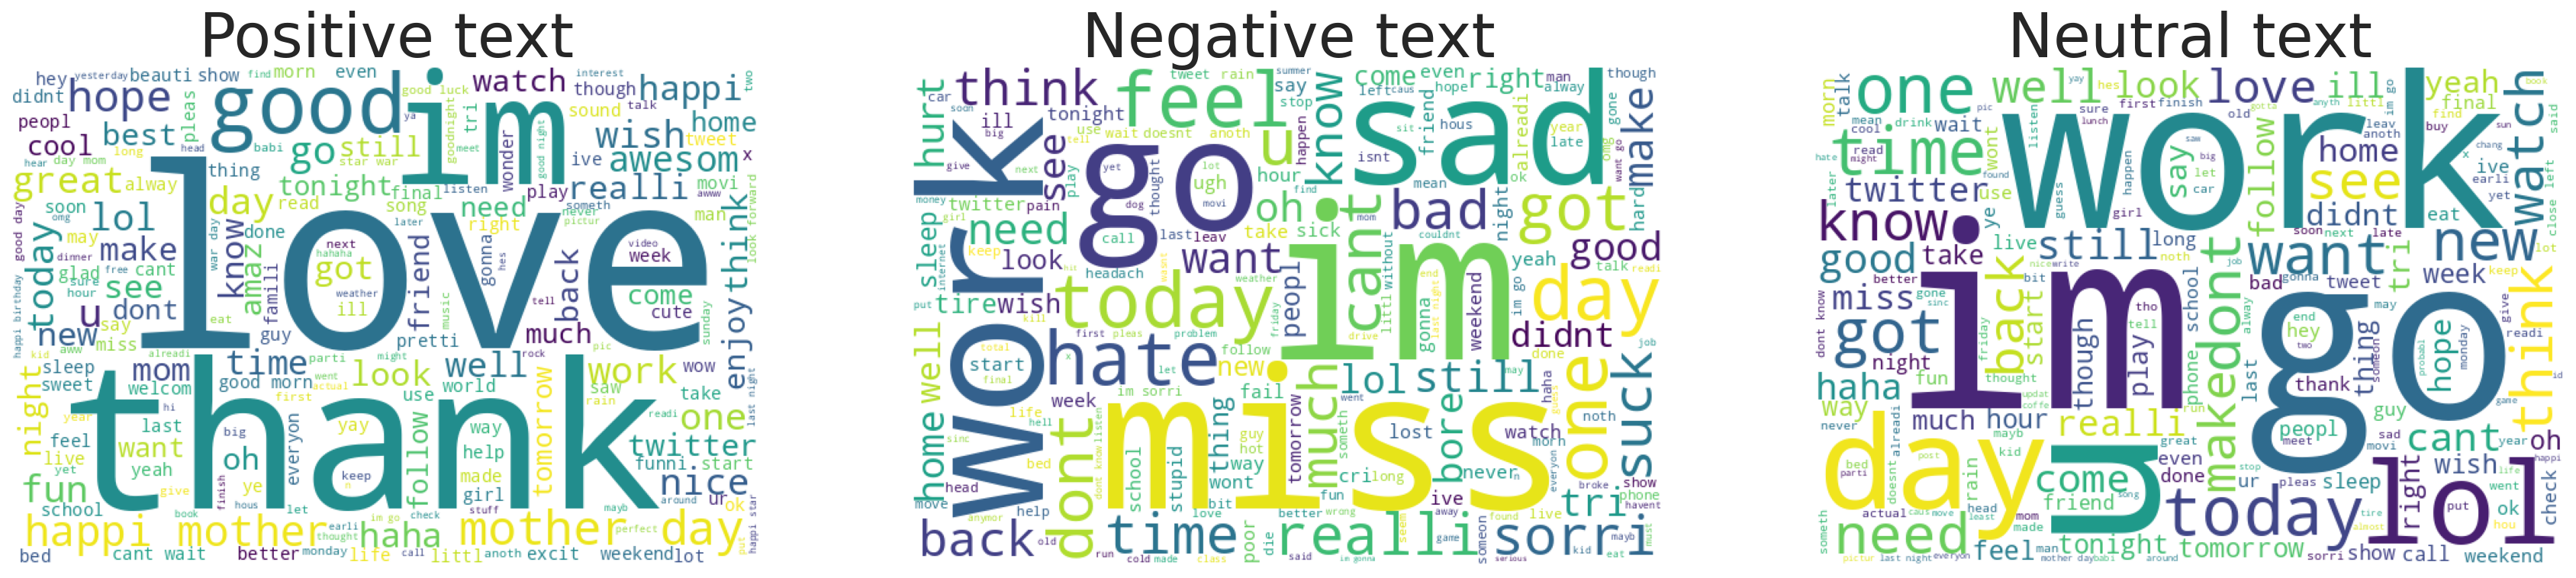

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])
wordcloud1 = WordCloud(background_color='white',
                       width=600,
                       height=400).generate(" ".join(positive_clean_words))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive text', fontsize=40)

wordcloud2 = WordCloud(background_color='white',
                       width=600,
                       height=400).generate(" ".join(negative_clean_words))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative text', fontsize=40)

wordcloud3 = WordCloud(background_color='white',
                       width=600,
                       height=400).generate(" ".join(neutral_clean_words))
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutral text', fontsize=40)

# Conclusion

In this work i try to made detailed analysis existing data. 

Was made investigation in next areas:

    - Missing Values treatment in the dataset
    - Distribution of the Sentiment Column
    - Text Data Preprocessing
    - Analyzing Text Statistics
    
What next:

1. You can experiment with clearing functions
2. You can make spelling analysis
2. You can use pretrained models for creating embedings